In [1]:
import sys
sys.path.append("../")

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-04-28 17:08:13.446780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Reading the CSV and images

In [3]:
dicom_dataset = pd.read_csv("../dataset/csv/dicom_info.csv")
mass_train= pd.read_csv("../dataset/csv/mass_case_description_train_set.csv")
mass_test = pd.read_csv("../dataset/csv/mass_case_description_test_set.csv")
calc_train = pd.read_csv("../dataset/csv/calc_case_description_train_set.csv")

In [4]:
dicom_dataset["PatientName"].nunique()

6575

In [5]:
mass_train["image file path"].values

array(['Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/000000.dcm',
       'Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/000000.dcm',
       'Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/000000.dcm',
       ...,
       'Mass-Training_P_02079_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.79168706212562046504764996222502629838/1.3.6.1.4.1.9590.100.1.2.412558050811722685411988228462651590663/000000.dcm',
       'Mass-Training_P_02092_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.420341693811920799600818661313506180250/1.3.6.1.4.1.9590.100.1.2.150311422512072857220647947940958267422/000000.dcm',
       'Mass-Training_P_02092_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.322851018411213611

In [6]:
image_paths = mass_train["image file path"].values
patient_ids = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    patient_ids.append(path.split(os.sep)[0])
    
mass_train["PatientID"] = patient_ids

In [7]:
image_paths = mass_test["image file path"].values
patient_ids = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    patient_ids.append(path.split(os.sep)[0])

mass_test["PatientID"] = patient_ids

In [8]:
mass_train = mass_train.merge(dicom_dataset[["PatientID", "image_path"]], on='PatientID', how='inner')
mass_test = mass_test.merge(dicom_dataset[["PatientID", "image_path"]], on='PatientID', how='inner')

In [9]:
image_paths = mass_train["image_path"].values
image_cropped_paths = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    x = path.split(os.sep)
    x[0] = "../dataset"
    image_cropped_paths.append(os.path.join(*x))
    
mass_train["fixed_image_paths"] = image_cropped_paths

In [10]:
image_paths = mass_test["image_path"].values
image_cropped_paths = []

for image_path in image_paths:
    path = os.path.normpath(image_path)
    x = path.split(os.sep)
    x[0] = "../dataset"
    image_cropped_paths.append(os.path.join(*x))
    
mass_test["fixed_image_paths"] = image_cropped_paths

In [11]:
mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,PatientID,image_path,fixed_image_paths
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.34238...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.35930...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.89180...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.29536...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.41052...


In [13]:
mass_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,PatientID,image_path,fixed_image_paths
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.245063...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.24506...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.859522...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.85952...
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.221311...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.22131...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.239949...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.23994...
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.215081...,../dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.21508...


In [18]:
train_dataset = mass_train[["PatientID", "pathology", "fixed_image_paths"]].loc[mass_train['pathology'].isin(["MALIGNANT", "BENIGN"])]
test_dataset = mass_test[["PatientID", "pathology", "fixed_image_paths"]].loc[mass_test['pathology'].isin(["MALIGNANT", "BENIGN"])]

In [19]:
train_dataset.to_csv("../dataset/csv/train.csv")
test_dataset.to_csv("../dataset/csv/test.csv")

In [13]:
train_labels = pd.factorize(train_dataset["pathology"].values)[0]
test_labels = pd.factorize(test_dataset["pathology"].values)[0]
train_dataset["labels"] = train_labels
test_dataset["labels"] = test_labels

In [14]:
images = []
for i, image_path in enumerate(train_dataset["fixed_image_paths"].values):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, (229, 229)).numpy().astype(np.uint8)/255.0
    images.append(image)
    
X_train = np.array(images)
Y_train = train_dataset["labels"].values

Metal device set to: Apple M1


2023-04-24 13:18:31.072628: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-24 13:18:31.072674: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
images = []
for i, image_path in enumerate(test_dataset["fixed_image_paths"].values):
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    image = tf.image.resize(image, (229, 229)).numpy().astype(np.uint8)/255.0
    images.append(image)
    
X_test = np.array(images)
Y_test = test_dataset["labels"].values

In [38]:
model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, input_shape=(229, 229, 3),  weights='imagenet')
for layer in model.layers:
    layer.trainable = False

x = Flatten()(model.output)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(model.input, x)

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), metrics=['accuracy', tf.keras.metrics.AUC()])

In [1]:
history = model.fit(x=X_train, y=Y_train, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

NameError: name 'model' is not defined

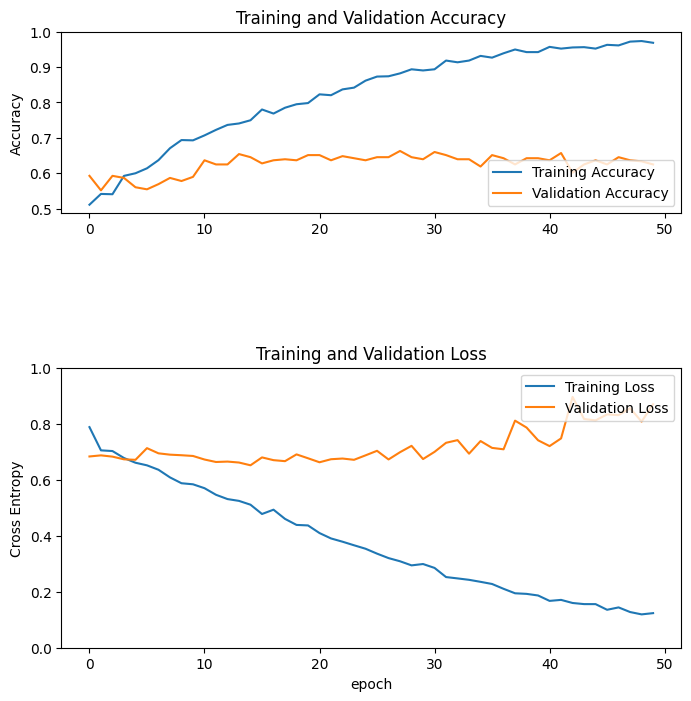

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

auc = history.history['auc_5']
val_auc = history.history['val_auc_5']

plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

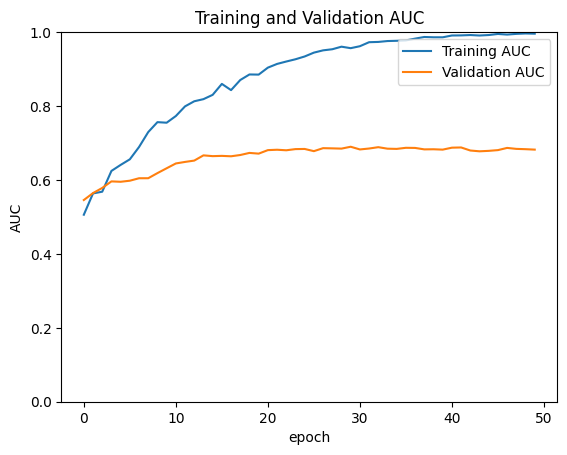

In [57]:
plt.plot(auc, label='Training AUC')
plt.plot(val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.ylabel('AUC')
plt.ylim([0,1.0])
plt.title('Training and Validation AUC')
plt.xlabel('epoch')
plt.show()